# [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/cene555/ruCLIP-SB/blob/main/notebooks/evaluate_ruCLIP_SB_latest.ipynb)

In [ ]:
#@title Allowed Resources
import multiprocessing
import torch
from psutil import virtual_memory

ram_gb = round(virtual_memory().total / 1024**3, 1)

print('CPU:', multiprocessing.cpu_count())
print('RAM GB:', ram_gb)
print("PyTorch version:", torch.__version__)
print("CUDA version:", torch.version.cuda)
print("cuDNN version:", torch.backends.cudnn.version())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device.type)

!nvidia-smi

CPU: 8
RAM GB: 51.0
PyTorch version: 1.10.0+cu111
CUDA version: 11.1
cuDNN version: 8005
device: cuda
Tue Feb  1 06:23:09 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    23W / 300W |      2MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------

## Install requirements

In [ ]:
%%capture
!pip install git+https://github.com/cene555/ru-clip-tiny.git
!gdown -O ru-clip-tiny.pkl https://drive.google.com/uc?id=1-3g3J90pZmHo9jbBzsEmr7ei5zm3VXOL
!gdown -O cifar100classes.json https://drive.google.com/uc?id=1ZJhOp5RP5wY31TyJgGNXa9xaJO8SdAhf

## Import libraries

In [ ]:
import torch
from torchvision import transforms
import transformers
from transformers import BertTokenizer
from rucliptiny import RuCLIPtiny
from rucliptiny.predictor import Predictor
from PIL import ImageCms
from rucliptiny.utils import get_transform
from rucliptiny.tokenizer import Tokenizer
import cv2

In [ ]:
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

## Load model

In [ ]:
import time

def speed_test(func, data_gen, n=5, empty_cache=True, is_text=False):
    if empty_cache: torch.cuda.empty_cache()
    values = []
    for _ in range(n):
        if is_text:
            input_data1, input_data2 = data_gen()
        else:
            input_data = data_gen()
        t = time.time()
        if is_text:
            func(input_data1, input_data2)
        else:
            func(input_data)
        values.append(time.time() - t)
        if empty_cache: torch.cuda.empty_cache()
    return sum(values) / n

In [ ]:
torch.manual_seed(1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
model = RuCLIPtiny()
model.load_state_dict(torch.load('/content/ru-clip-tiny.pkl', map_location=device))
model = model.to(device).eval()
for x in model.parameters(): x.requires_grad = False
torch.cuda.empty_cache()

## Speed test

In [ ]:
speed_test(model.encode_image, lambda: torch.randint(1, 255, (64, 3, 224, 224)).to(device))

0.012924861907958985

In [ ]:
speed_test(model.encode_text, lambda: (torch.randint(1, 255, (64, 77)).to(device), torch.randint(0, 1, (64, 77)).to(device)), is_text=True)

0.0046023368835449215

## Show similarity

In [ ]:
# @title Define show_test_images function

import json
import os
import skimage
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from collections import Counter
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor


def show_test_images():
    input_resolution = 224
    preprocess = Compose([
        Resize(input_resolution, interpolation=Image.BICUBIC),
        CenterCrop(input_resolution),
        ToTensor()
    ])
    descriptions = {
        'page': 'страница текста о сегментации',
        'chelsea': 'фото морды полосатого кота',
        'astronaut': 'портрет космонавта с американским флагом',
        'rocket': 'ракета стоит на стартовой площадке',
        'motorcycle_right': 'красный мотоцикл стоит в гараже',
        'camera': 'человек смотрит в камеру на штативе',
        'horse': 'черно-белый силуэт лошади',
        'coffee': 'чашка кофе на блюдце'
    }
    images = []
    texts = []
    plt.figure(figsize=(16, 5))
    img_paths = []

    for filename in [filename for filename in os.listdir(skimage.data_dir) if
                     filename.endswith('.png') or filename.endswith('.jpg')]:
        name = os.path.splitext(filename)[0]
        if name not in descriptions:
            continue
        fn = os.path.join(skimage.data_dir, filename)
        img_paths.append(fn)
        image = preprocess(Image.open(fn).convert('RGB'))
        images.append(fn)
        texts.append(descriptions[name])

        plt.subplot(2, 4, len(images))
        plt.imshow(image.permute(1, 2, 0))
        plt.title(f'{filename}\n{descriptions[name]}')
        plt.xticks([])
        plt.yticks([])

    plt.tight_layout()
    return images, texts

In [ ]:
# @title Define show_similarity function

def show_similarity(images, texts, similarity):
    input_resolution = 224
    preprocess = Compose([
        Resize(input_resolution, interpolation=Image.BICUBIC),
        CenterCrop(input_resolution),
        ToTensor()
    ])
    count = len(texts)

    plt.figure(figsize=(20, 14))
    plt.imshow(similarity, vmin=0.1, vmax=0.3)
    plt.yticks(range(count), texts, fontsize=18)
    plt.xticks([])
    for i, image in enumerate(images):
        if isinstance(image, str):
            image = Image.open(image)
            image = preprocess(image.convert('RGB'))
        plt.imshow(image.permute(1, 2, 0), extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin='lower')
    for x in range(similarity.shape[1]):
        for y in range(similarity.shape[0]):
            plt.text(x, y, f'{similarity[y, x]:.2f}', ha='center', va='center', size=12)

    for side in ['left', 'top', 'right', 'bottom']:
        plt.gca().spines[side].set_visible(False)

    plt.xlim([-0.5, count - 0.5])
    plt.ylim([count + 0.5, -2])

    plt.title('Cosine similarity between text and image features', size=20)

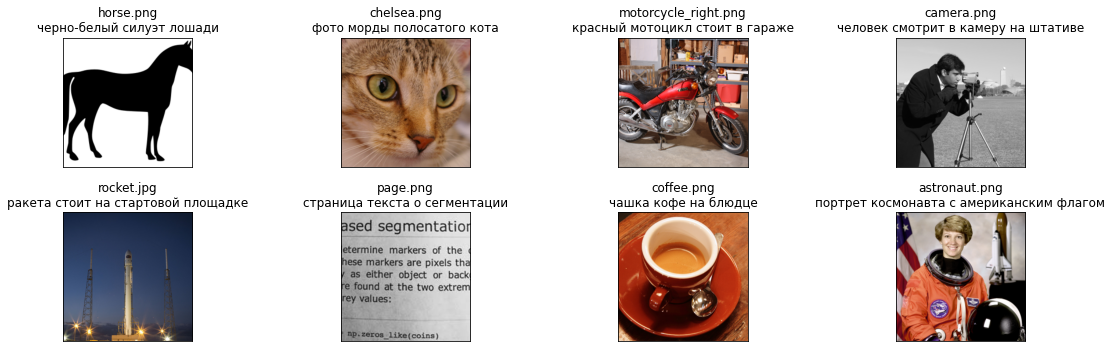

In [ ]:
images, texts = show_test_images()

In [ ]:
predictor = Predictor()

Downloading:   0%|          | 0.00/373k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/175 [00:00<?, ?B/s]

In [ ]:
text_probs = predictor(model=model, images_path=images,
                       classes=texts, get_probs=True,
                       max_len=77, device=device)

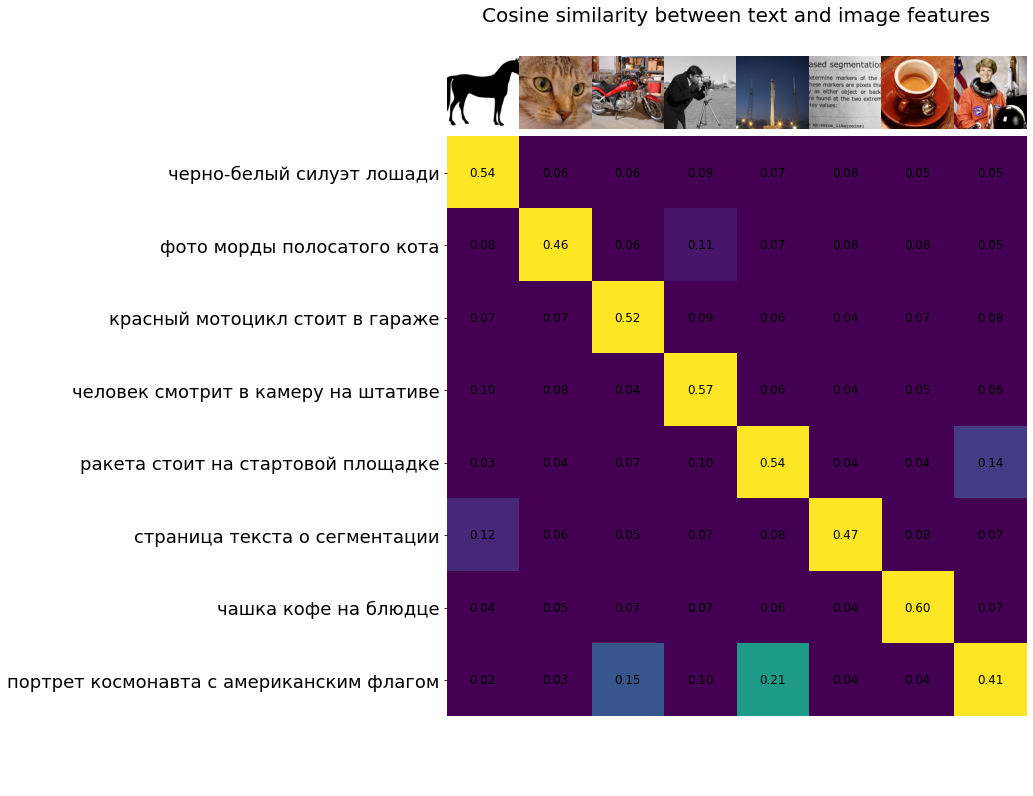

In [ ]:
similarity = text_probs.cpu().numpy()
_ = show_similarity(images, texts, similarity)

## Evaluate on Cifar100 dataset

In [ ]:
# @title Specific functions

from torchvision.datasets import CIFAR100
import os
import json
from tqdm.auto import tqdm
import torch


def prepare_classes(classes):
    return [f"{label.lower()}" for label in classes]


def get_text_probs_from_dataset(
        model,
        tokenizer=None,
        ds=None,
        train=False,
        classes_path=None,
        text_descriptions=None,
        transform=None
):
    if ds is None:
        cls = CIFAR100
        ds = cls(os.path.expanduser("~/.cache"), download=True, train=train)
        if classes_path is None:
            classes_path = f"../clip/evaluate/{name.lower()}/{name.lower()}classes.json"
        with open(classes_path, "r") as file:
            ds.classes = json.load(file)
    if text_descriptions is None:
        text_descriptions = prepare_classes(ds.classes)
    text_input = tokenizer.tokenize(text_descriptions).to(device)
    probs = []
    labels = []
    with torch.no_grad():
        text_features = model.encode_text(text_input[0], text_input[1]).float()
        text_features /= text_features.norm(dim=-1, keepdim=True)
        for x in tqdm(ds, total=len(ds)):
            images = [transform(x[0])]
            image_features = model.encode_image(torch.stack(images).to(device)).float()
            image_features /= image_features.norm(dim=-1, keepdim=True)
            text_probs = (1 * image_features @ text_features.T).softmax(dim=-1)
            labels.append(x[1])
            probs.append(text_probs.tolist()[0])
    return probs, labels


def get_topk_accuracy(labels, probs, k=5):
    successes = 0
    for lbl, p in zip(labels, np.array(probs)):
        _, top_labels = torch.tensor(p).topk(k, dim=-1)
        if lbl in top_labels:
            successes += 1
    return successes / len(labels)

In [ ]:
transform = get_transform()
tokenizer = Tokenizer()

In [ ]:
probs, labels = get_text_probs_from_dataset(
    model, tokenizer,
    classes_path="cifar100classes.json", transform=transform)

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting /root/.cache/cifar-100-python.tar.gz to /root/.cache


  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
get_topk_accuracy(labels, probs, k=5)

0.7318

In [ ]:
get_topk_accuracy(labels, probs, k=1)

0.4662